# Neste notebook, vamos usar outra técnica de redução de dimensionalidade em aprendizado de máquina:
# **Análise de Discriminantes Lineares**

In [1]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split

sns.set()
import os

import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:
from sklearn.datasets import load_iris

iris_data = load_iris(as_frame=True)
iris_data = iris_data.frame

# Preparação dos dados - SEM LDA

In [3]:
dados = torch.tensor(
    iris_data.values, dtype=torch.float32
)  # Convert DataFrame to NumPy array using .values
X = dados[:, 0:4]
d = dados[:, 4]

dados_treino, dados_teste, d_treino, d_teste = train_test_split(
    X, d, test_size=0.30, random_state=42
)

train_set = [(dados_treino[i, :], d_treino[i]) for i in range(dados_treino.shape[0])]

test_set = [(dados_teste[i, :], d_teste[i]) for i in range(dados_teste.shape[0])]

# Preparação dos dados - com LDA

lb
 tensor([3.2210e+01, 2.8813e-01, 5.6449e-06, 5.0326e-07])
W_K
 tensor([[-0.2076, -0.0037],
        [-0.3874,  0.5925],
        [ 0.5535, -0.2463],
        [ 0.7074,  0.7670]])


<Figure size 640x480 with 0 Axes>

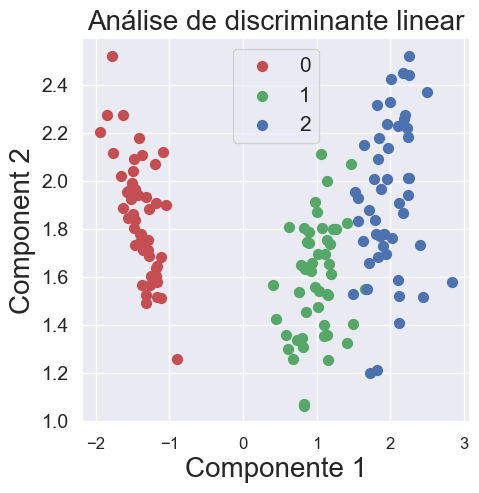

In [4]:
# Média de cada classe
X0_mean = torch.mean(X[0:49, :], axis=0)
X1_mean = torch.mean(X[50:99, :], axis=0)
X2_mean = torch.mean(X[100:150, :], axis=0)

S0 = (X[0:49, :] - X0_mean).T @ (X[0:49, :] - X0_mean)
S1 = (X[50:99, :] - X1_mean).T @ (X[50:99, :] - X1_mean)
S2 = (X[100:150, :] - X2_mean).T @ (X[100:150, :] - X2_mean)

Sw = S0 + S1 + S2

X_mean = torch.mean(X, axis=0)

N0 = 50
N1 = 50
N2 = 50
Sb = (
    N0 * (X0_mean - X_mean).reshape(-1, 1) @ (X0_mean - X_mean).reshape(-1, 1).T
    + N1 * (X1_mean - X_mean).reshape(-1, 1) @ (X1_mean - X_mean).reshape(-1, 1).T
    + N2 * (X2_mean - X_mean).reshape(-1, 1) @ (X2_mean - X_mean).reshape(-1, 1).T
)

S = torch.linalg.solve(Sw, Sb)

# Autovalores e Autovetores
lb, w = torch.linalg.eig(S)
lb = lb.real
w = w.real
print("lb\n", lb)

# Vamos considerara K-1 = 2 autovetores
K = 3
K_1 = K - 1
W_K = w[:, 0].reshape(-1, 1)
if K_1 > 1:
    for i in range(1, K_1):
        W_K = torch.cat([W_K, w[:, i].reshape(-1, 1)], dim=1)

print("W_K\n", W_K)

# Aplicando a transformação nos dados para gerar as features
P = X @ W_K

if K_1 == 1:
    P = P.reshape(-1, 1)


dados_treino_lda, dados_teste_lda, d_treino_lda, d_teste_lda = train_test_split(
    P, d, test_size=0.30, random_state=42
)

train_set_lda = [
    (dados_treino_lda[i, 0:K_1], d_treino_lda[i])
    for i in range(dados_treino_lda.shape[0])
]

test_set_lda = [
    (dados_teste_lda[i, 0:K_1], d_teste_lda[i]) for i in range(dados_teste_lda.shape[0])
]

P_df = pd.DataFrame(P.numpy())
P_df["target"] = d.numpy()

if K_1 > 1:
    plt.figure()
    plt.figure(figsize=(5, 5))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=14)
    plt.xlabel("Componente 1", fontsize=20)
    plt.ylabel("Component 2", fontsize=20)
    plt.title("Análise de discriminante linear", fontsize=20)
    targets = ["0", "1", "2"]
    colors = ["r", "g", "b"]
    for target, color in zip(targets, colors):
        indices = P_df["target"] == int(target)
        plt.scatter(P_df.loc[indices, 0], P_df.loc[indices, 1], c=color, s=50)

    plt.legend(targets, prop={"size": 15})

# Dados gerais do modelo


In [5]:
# Ajuste de hiperparâmetros

# passo de adaptação da rede MLP
eta = 0.001

# Tamanho do mini-batch
Nb = 16

# Número de épocas
Ne = 1000

# Modelo sem LDA


In [6]:
class Model(nn.Module):
    # Geralmente, os blocos da rede são definidos no método __init__()
    def __init__(self):
        # Necessário chamar __init__() da classe mãe
        super().__init__()

        # Uma das formas de se definir um modelo é a sequencial
        self.model = nn.Sequential(
            # Entrada com 4 elementos, conectada a 16 neurônios
            nn.Linear(4, 16),
            # Função de ativação ReLU
            nn.ReLU(),
            # Saídas de 16 neurônios conectadas a 8 neurônios
            nn.Linear(16, 8),
            nn.Dropout(0.2),
            nn.ReLU(),
            # Saídas de 8 neurônios conectadas a 3 neurônios
            nn.Linear(8, 3),
        )

    # O método forward() define como é feito o cálculo progressivo
    # para obter a saída da rede, a partir da entrada x.
    # Nesse caso, como foi definido um modelo sequencial em
    # self.model, basta chamar self.model(x)
    def forward(self, x):
        output = self.model(x)
        return output

# Modelo com LDA

In [7]:
class Model_lda(nn.Module):
    # Geralmente, os blocos da rede são definidos no método __init__()
    def __init__(self, K_1):
        # Necessário chamar __init__() da classe mãe
        super().__init__()
        self.K_1 = K_1

        # Uma das formas de se definir um modelo é a sequencial
        self.model = nn.Sequential(
            # Entrada com K_1 elementos, conectada a 16 neurônios
            nn.Linear(K_1, 16),
            # Função de ativação ReLU
            nn.ReLU(),
            # Saídas de 16 neurônios conectadas a 8 neurônios
            nn.Linear(16, 8),
            nn.Dropout(0.2),
            nn.ReLU(),
            # Saídas de 8 neurônios conectadas a 3 neurônios
            nn.Linear(8, 3),
        )

    # O método forward() define como é feito o cálculo progressivo
    # para obter a saída da rede, a partir da entrada x.
    # Nesse caso, como foi definido um modelo sequencial em
    # self.model, basta chamar self.model(x)
    def forward(self, x):
        output = self.model(x)
        return output

# Modelo mais simples com LDA

In [8]:
class Model_lda2(nn.Module):
    # Geralmente, os blocos da rede são definidos no método __init__()
    def __init__(self, K_1):
        # Necessário chamar __init__() da classe mãe
        super().__init__()
        self.K_1 = K_1

        # Uma das formas de se definir um modelo é a sequencial
        self.model = nn.Sequential(
            # Entrada com K_1 elementos, conectada a 3 neurônios
            nn.Linear(K_1, 3),
            # Função de ativação ReLU
            nn.ReLU(),
            # Saídas de 3 neurônio conectadas a 3 neurônios
            nn.Linear(3, 3),
        )

    # O método forward() define como é feito o cálculo progressivo
    # para obter a saída da rede, a partir da entrada x.
    # Nesse caso, como foi definido um modelo sequencial em
    # self.model, basta chamar self.model(x)
    def forward(self, x):
        output = self.model(x)
        return output

In [9]:
device = torch.device("cpu")
model = Model().to(device=device)
model_lda = Model_lda(K_1).to(device=device)
model_lda2 = Model_lda2(K_1).to(device=device)


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Linear") != -1:
        torch.nn.init.kaiming_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)


model.apply(weights_init)
model_lda.apply(weights_init)
model_lda2.apply(weights_init)


loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
optimizer_lda = torch.optim.Adam(model_lda.parameters(), lr=eta)
optimizer_lda2 = torch.optim.Adam(model_lda2.parameters(), lr=eta)

# Função para avaliar o modelo

In [10]:
def evaluate(model, test_loader):
    model.eval()
    correto = 0
    total = 0
    with torch.no_grad():  # Não calcular os gradientes durante a avaliação
        for X, d in test_loader:
            y = model(X)
            _, predito = torch.max(y, 1)
            total += d.size(0)
            correto += (predito == d).sum().item()

    print(f"Acurácia no conjunto de teste: {100 * correto / total:.2f}%")

# Treinamento e avaliação dos modelos

Treinamento do modelo sem LDA

Época: 0 Loss: 4.9891180992126465 Acurácia: 28.12%
Época: 10 Loss: 1.321790099143982 Acurácia: 26.04%
Época: 20 Loss: 1.271712064743042 Acurácia: 35.42%
Época: 30 Loss: 0.8711224794387817 Acurácia: 48.96%
Época: 40 Loss: 0.8241434097290039 Acurácia: 47.92%
Época: 50 Loss: 0.8509100675582886 Acurácia: 41.67%
Época: 60 Loss: 0.7084008455276489 Acurácia: 54.17%
Época: 70 Loss: 0.6821413040161133 Acurácia: 67.71%
Época: 80 Loss: 0.6438747048377991 Acurácia: 54.17%
Época: 90 Loss: 0.6422181725502014 Acurácia: 61.46%
Época: 100 Loss: 0.704110860824585 Acurácia: 59.38%
Época: 110 Loss: 0.7356888055801392 Acurácia: 60.42%
Época: 120 Loss: 0.5285730957984924 Acurácia: 56.25%
Época: 130 Loss: 0.48300236463546753 Acurácia: 61.46%
Época: 140 Loss: 0.2930540442466736 Acurácia: 84.38%
Época: 150 Loss: 0.49406254291534424 Acurácia: 89.58%
Época: 160 Loss: 0.222005695104599 Acurácia: 88.54%
Época: 170 Loss: 0.32909101247787476 Acurácia: 88.54%
Época: 180 Loss: 0.43165725469589233 Acurácia: 80.21%
Époc

Text(0, 0.5, 'Loss')

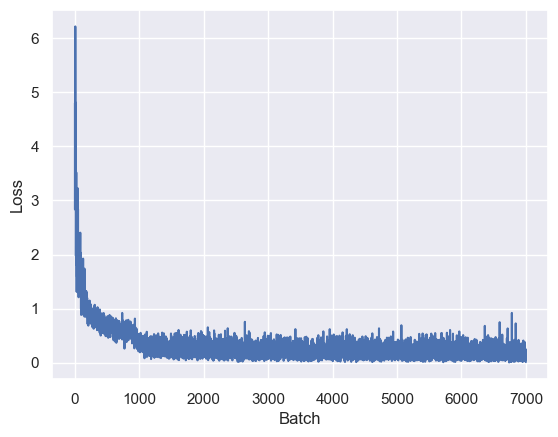

In [11]:
# Carregando os dados de treinamento
train_loader = torch.utils.data.DataLoader(train_set, batch_size=Nb, shuffle=True)

# Lista usada para guardar o valor da função custo ao longo das iterações
losses = []

# Loop das épocas
for epoch in range(Ne):
    correto = 0
    total = 0
    # Loop dos mini batches - note que é usado o DataLoader para obter
    # os sinais de entrada e desejado, X e d
    for n, (X, d) in enumerate(train_loader):
        # from IPython import embed; embed()
        # Envia os dados para a GPU, caso ela exista
        X = X.to(device=device)
        d = d.type(torch.LongTensor).to(device=device)

        # Coloca o modelo em modo treinamento. Isso não é necessário nesse
        # caso, pois não estamos fazendo validação. Mas é interessante manter
        # a linha para lembrar desse detalhe
        model.train()

        # Zera informações de gradientes: por padrão o PyTorch acumula os
        # gradientes a cada chamada de loss.backward(). Na maioria dos casos,
        # estamos interessados apenas no último valor dos gradientes
        model.zero_grad()

        # Calcula a saída
        y = model(X)

        # Calcula o valor da função custo
        loss = loss_function(y, d)

        # Calcula os gradientes
        loss.backward()

        # Atualiza os pesos do modelo, de acordo com as regras
        # do otimizador escolhido
        optimizer.step()

        # Armazena o valor da função custo
        losses.append(loss.item())

        # Calcula a acurácia
        _, predito = torch.max(y, 1)
        total += d.size(0)
        correto += (predito == d).sum().item()

        # Mostra o valor da função custo a cada 500 épocas
        if epoch % 10 == 0 and n == dados_treino.shape[0] // Nb - 1:
            print(f"Época: {epoch} Loss: {loss} Acurácia: {100 * correto / total:.2f}%")
#

plt.figure()
plt.plot(losses)
plt.xlabel("Batch")
plt.ylabel("Loss")

Avaliação do Modelo sem LDA

In [12]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=Nb, shuffle=False)
evaluate(model, test_loader)

Acurácia no conjunto de teste: 100.00%


Treinamento do Modelo com LDA

Época: 0 Loss: 1.2988768815994263 Acurácia: 37.50%
Época: 10 Loss: 0.8350884318351746 Acurácia: 39.58%
Época: 20 Loss: 0.6535545587539673 Acurácia: 73.96%
Época: 30 Loss: 0.5888229012489319 Acurácia: 83.33%
Época: 40 Loss: 0.3734115958213806 Acurácia: 84.38%
Época: 50 Loss: 0.3989080488681793 Acurácia: 91.67%
Época: 60 Loss: 0.26609721779823303 Acurácia: 91.67%
Época: 70 Loss: 0.3316937983036041 Acurácia: 89.58%
Época: 80 Loss: 0.17549565434455872 Acurácia: 94.79%
Época: 90 Loss: 0.19023969769477844 Acurácia: 91.67%
Época: 100 Loss: 0.28575825691223145 Acurácia: 90.62%
Época: 110 Loss: 0.3089480400085449 Acurácia: 92.71%
Época: 120 Loss: 0.4176167845726013 Acurácia: 92.71%
Época: 130 Loss: 0.17491212487220764 Acurácia: 93.75%
Época: 140 Loss: 0.23097987473011017 Acurácia: 94.79%
Época: 150 Loss: 0.46239206194877625 Acurácia: 92.71%
Época: 160 Loss: 0.1575651913881302 Acurácia: 96.88%
Época: 170 Loss: 0.1902671605348587 Acurácia: 95.83%
Época: 180 Loss: 0.06922309100627899 Acurácia: 94.

Text(0, 0.5, 'Loss_lda')

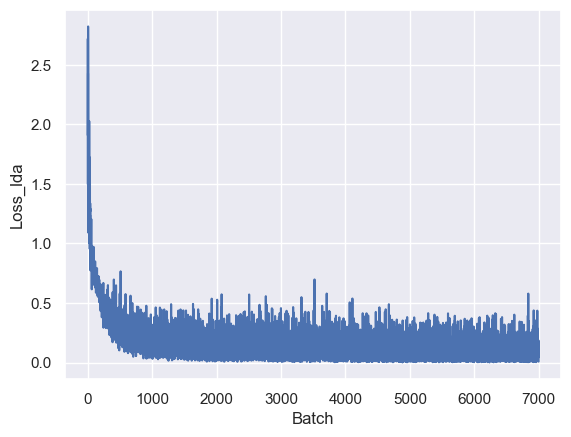

In [13]:
# Carregando os dados de treinamento
train_loader_lda = torch.utils.data.DataLoader(
    train_set_lda, batch_size=Nb, shuffle=True
)

# Lista usada para guardar o valor da função custo ao longo das iterações
losses_lda = []

# Loop das épocas
for epoch in range(Ne):
    correto = 0
    total = 0
    # Loop dos mini batches - note que é usado o DataLoader para obter
    # os sinais de entrada e desejado, X e d
    for n, (X, d) in enumerate(train_loader_lda):
        # from IPython import embed; embed()
        # Envia os dados para a GPU, caso ela exista
        X = X.to(device=device)
        d = d.type(torch.LongTensor).to(device=device)

        # Coloca o modelo em modo treinamento. Isso não é necessário nesse
        # caso, pois não estamos fazendo validação. Mas é interessante manter
        # a linha para lembrar desse detalhe
        model_lda.train()

        # Zera informações de gradientes: por padrão o PyTorch acumula os
        # gradientes a cada chamada de loss.backward(). Na maioria dos casos,
        # estamos interessados apenas no último valor dos gradientes
        model_lda.zero_grad()

        # Calcula a saída
        y = model_lda(X)

        # Calcula o valor da função custo
        loss = loss_function(y, d)

        # Calcula os gradientes
        loss.backward()

        # Atualiza os pesos do modelo, de acordo com as regras
        # do otimizador escolhido
        optimizer_lda.step()

        # Armazena o valor da função custo
        losses_lda.append(loss.item())

        # Calcula a acurácia
        _, predito = torch.max(y, 1)
        total += d.size(0)
        correto += (predito == d).sum().item()

        # Mostra o valor da função custo a cada 500 épocas
        if epoch % 10 == 0 and n == dados_treino.shape[0] // Nb - 1:
            print(f"Época: {epoch} Loss: {loss} Acurácia: {100 * correto / total:.2f}%")


plt.figure()
plt.plot(losses_lda)
plt.xlabel("Batch")
plt.ylabel("Loss_lda")

Avaliação do Modelo com LDA

In [14]:
test_loader_lda = torch.utils.data.DataLoader(
    test_set_lda, batch_size=Nb, shuffle=False
)
evaluate(model_lda, test_loader_lda)

Acurácia no conjunto de teste: 97.78%


Treinamento do Modelo mais simples com LDA

Época: 0 Loss: 2.099639892578125 Acurácia: 33.33%
Época: 10 Loss: 1.4852852821350098 Acurácia: 35.42%
Época: 20 Loss: 1.113702416419983 Acurácia: 39.58%
Época: 30 Loss: 0.729254961013794 Acurácia: 57.29%
Época: 40 Loss: 0.8830803632736206 Acurácia: 64.58%
Época: 50 Loss: 0.7323137521743774 Acurácia: 66.67%
Época: 60 Loss: 0.5043088793754578 Acurácia: 91.67%
Época: 70 Loss: 0.48512816429138184 Acurácia: 94.79%
Época: 80 Loss: 0.4192712903022766 Acurácia: 94.79%
Época: 90 Loss: 0.5127632021903992 Acurácia: 95.83%
Época: 100 Loss: 0.3510049283504486 Acurácia: 96.88%
Época: 110 Loss: 0.3269091248512268 Acurácia: 96.88%
Época: 120 Loss: 0.31736645102500916 Acurácia: 96.88%
Época: 130 Loss: 0.2909601926803589 Acurácia: 96.88%
Época: 140 Loss: 0.27138751745224 Acurácia: 98.96%
Época: 150 Loss: 0.22614920139312744 Acurácia: 96.88%
Época: 160 Loss: 0.24082458019256592 Acurácia: 97.92%
Época: 170 Loss: 0.2406138777732849 Acurácia: 97.92%
Época: 180 Loss: 0.2750583291053772 Acurácia: 97.92%
Época

Text(0, 0.5, 'Loss_lda + simples')

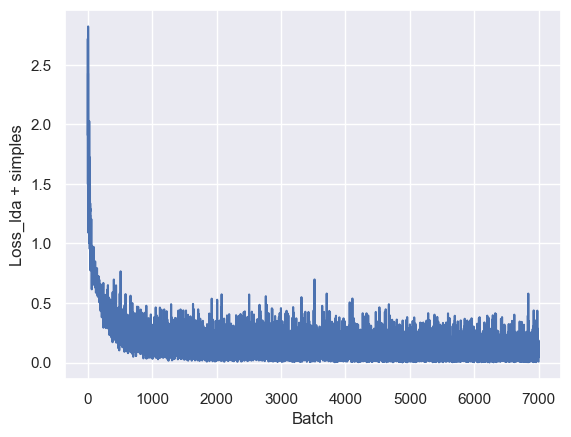

In [15]:
# Carregando os dados de treinamento
train_loader_lda2 = torch.utils.data.DataLoader(
    train_set_lda, batch_size=Nb, shuffle=True
)

# Lista usada para guardar o valor da função custo ao longo das iterações
losses_lda2 = []

# Loop das épocas
for epoch in range(Ne):
    correto = 0
    total = 0
    # Loop dos mini batches - note que é usado o DataLoader para obter
    # os sinais de entrada e desejado, X e d
    for n, (X, d) in enumerate(train_loader_lda2):
        # from IPython import embed; embed()
        # Envia os dados para a GPU, caso ela exista
        X = X.to(device=device)
        d = d.type(torch.LongTensor).to(device=device)

        # Coloca o modelo em modo treinamento. Isso não é necessário nesse
        # caso, pois não estamos fazendo validação. Mas é interessante manter
        # a linha para lembrar desse detalhe
        model_lda2.train()

        # Zera informações de gradientes: por padrão o PyTorch acumula os
        # gradientes a cada chamada de loss.backward(). Na maioria dos casos,
        # estamos interessados apenas no último valor dos gradientes
        model_lda2.zero_grad()

        # Calcula a saída
        y = model_lda2(X)

        # Calcula o valor da função custo
        loss = loss_function(y, d)

        # Calcula os gradientes
        loss.backward()

        # Atualiza os pesos do modelo, de acordo com as regras
        # do otimizador escolhido
        optimizer_lda2.step()

        # Armazena o valor da função custo
        losses_lda2.append(loss.item())

        # Calcula a acurácia
        _, predito = torch.max(y, 1)
        total += d.size(0)
        correto += (predito == d).sum().item()

        # Mostra o valor da função custo a cada 500 épocas
        if epoch % 10 == 0 and n == dados_treino.shape[0] // Nb - 1:
            print(f"Época: {epoch} Loss: {loss} Acurácia: {100 * correto / total:.2f}%")


plt.figure()
plt.plot(losses_lda)
plt.xlabel("Batch")
plt.ylabel("Loss_lda + simples")

Avaliação do Modelo mais simples com LDA

In [16]:
test_loader_lda2 = torch.utils.data.DataLoader(
    test_set_lda, batch_size=Nb, shuffle=False
)
evaluate(model_lda2, test_loader_lda2)

Acurácia no conjunto de teste: 97.78%


In [17]:
lbb, wb = torch.linalg.eig(Sb)
lbb = lb.real
wb = wb.real
print("lb\n", lb)
r = torch.linalg.matrix_rank(Sb)
print("r\n", r)

lb
 tensor([3.2210e+01, 2.8813e-01, 5.6449e-06, 5.0326e-07])
r
 tensor(2)
